In [2]:
from torchtext.vocab import GloVe

# Load pre-trained Word2Vec embeddings(GloVe)
word_embeddings = GloVe(name='6B', dim=100)

In [1]:
import sys
sys.path.append('../')  # Add the parent folder to the system path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from artificial_nn import ANN
import util.preprocess as preprocess

# use below line for local use
# extracted_df = pd.read_csv("./nacc_processed.csv").astype("float")


# use below lines assuming you only have raw data (not filtered one)

data = pd.read_csv("./investigator_ftldlbd_nacc65.csv")

/var/folders/k3/5pd3dh6x5l14qp9rwq3glw0w0000gn/T/ipykernel_17051/1279730832.py:18: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010,1029,1034,1204,1208,1211,1407,1409,1411,1412,1414,1421,1423,1425,1426,1433,1435,1437,1439,1440,1447,1462,1476,1490,1504,1506,1542,1558,1560,1562,1564,1566,1568,1570,1572,1574,1576,1578,1580,1582,1584,1586,1588,1590,1592,1594,1596,1598,1600,1602,1604,1606,1608,1610,1612,1662,1663,1665,1666,1669,1670,1673,1674,1677,1678,1681,1682,1756,1815,1824,1826,1828,1830,1841,1843,1845,1853,1855,1857,1859,1867,1869,1871,1873,1899) 

In [3]:
data['VISITDAY'] = data['VISITDAY'].astype(str).str.zfill(2)
data['VISITMO'] = data['VISITMO'].astype(str).str.zfill(2)
data['VISITYR'] = data['VISITYR'].astype(str)
data['VISITDT'] = data['VISITYR'] + data['VISITMO'] + data['VISITDAY']

columns_to_use = ['NACCID', 'VISITDT','NACCMOCA','CRAFTDRE','COMMUN','NACCMMSE','HOMEHOBB','JUDGMENT','LOGIMEM','CDRSUM','MEMORY', 'BOSTON', 'MINTTOTS', 'ANIMALS', 'MEMUNITS', 'TRAILB', 'NACCUDSD']
extracted_df = data[columns_to_use]
extracted_df = extracted_df.sort_values(by=["NACCID", "VISITDT"], ascending=True)
new_csv = './nacc_processed.csv'
# write the DataFrame to a CSV file
extracted_df.to_csv(new_csv, index=False)

In [4]:
features_to_impute = columns_to_use[2:-1]

def forward_and_backward_impute(group):
    for feature in features_to_impute:
        if feature == "NACCMOCA" or feature == "NACCMMSE":
            group[feature] = group[feature].replace([-4,88,99], pd.NA)
        else:
            # replace -4 and 99 with nan for processing
            group[feature] = group[feature].replace([-4,99], pd.NA)
        # forward fill nan values
        group[feature] = group[feature].ffill()
        # backward fill nan values
        group[feature] = group[feature].bfill()
    return group

# Group by patient_id and apply forward and backward impute function
extracted_df = extracted_df.groupby('NACCID').apply(forward_and_backward_impute)

for feature in features_to_impute:
    extracted_df[feature] = extracted_df[feature].fillna(-4)

new_csv = './fb_imputed.csv'
# write the DataFrame to a CSV file
extracted_df.to_csv(new_csv, index=False)

In [11]:
severity_value_pairs  = {
    "CRAFTDRE" : [95,96,97,98],
    "LOGIMEM" : [95,96,97,98],
    "NACCMMSE" : [95,96,97,98],
    "BOSTON" : [95,96,97,98],
    "MINTTOTS" : [95,96,97,98],
    "ANIMALS" : [95,96,97,98],
    "MEMUNITS" : [95,96,97,98],
    "TRAILB" : [995,996,997,998],
}

include_severity_vals = list(severity_value_pairs.keys())

# create a seperate column for severity cases - binary indicator
for col in include_severity_vals:
    for val in severity_value_pairs[col]:
        extracted_df[f"{col}_{val}"] = (extracted_df[col] == val).astype(int)

# replace all severity values with NaN - ensure gloablity, easier to compare
for col, severity_values in severity_value_pairs.items():
    extracted_df[col] = extracted_df[col].replace(severity_values, np.nan)

# imputation values is a dictionary that contains mean values of columns with each label
# keys : column names , values : list with 4 (number of labels) values
imputation_values = {}

for col in severity_value_pairs.keys():
    means = []
    for label in range(1,5):
        means.append(extracted_df[extracted_df["NACCUDSD"] == label][col].mean())
    imputation_values[col] = means

# replace each missing value with its imputation values
for index, row in extracted_df.iterrows():
    for col in severity_value_pairs.keys():
        if np.isnan(row[col]):
            label = row["NACCUDSD"]
            imputation_val = imputation_values[col][label - 1]
            extracted_df.at[index, col] = imputation_val

main_df = extracted_df

preprocess.put_the_column_at_end(main_df, "NACCUDSD")

NACCID   VISITDT   NACCMOCA   CRAFTDRE  COMMUN  \
NACCID                                                                  
NACC000011 31511   NACC000011  20060417  22.128461  14.027943     0.0   
           31512   NACC000011  20070618  22.128461  14.027943     0.0   
           31513   NACC000011  20080603  22.128461  14.027943     0.0   
           31514   NACC000011  20090803  24.337459  15.281494     0.0   
NACC000034 183244  NACC000034  20150716  27.000000  16.000000     0.0   
...                       ...       ...        ...        ...     ...   
NACC999872 158296  NACC999872  20230321  20.000000  16.594988     0.0   
NACC999922 57864   NACC999922  20120807  26.135680  20.016361     0.0   
           57865   NACC999922  20130806  26.135680  20.016361     0.0   
NACC999954 85160   NACC999954  20060327  14.621541  23.600056     0.5   
NACC999969 57866   NACC999969  20091102  26.135680  20.016361     0.0   

                    NACCMMSE  HOMEHOBB  JUDGMENT    LOGIMEM  CDRSUM  ...  \
NACCID                                                               ...   
NACC000011 31511   30.000000       0.0       0.0  12.000000     0.5  ...   
           31512   29.000000       0.0       0.0  13.000000     0.5  ...   
           31513   30.000000       0.0       0.0  12.000000     0.5  ...   
           31514   28.000000       0.0       0.0  11.000000     0.5  ...   
NACC000034 183244  28.591694       0.0       0.0  12.796396     0.5  ...   
...                      ...       ...       ...        ...     ...  ...   
NACC999872 158296  29.000000       0.0       0.0  15.533824     0.0  ...   
NACC999922 57864   30.000000       0.0       0.0  19.000000     0.0  ...   
           57865   30.000000       0.0       0.0  12.000000     0.0  ...   
NACC999954 85160   23.000000       0.5       1.0   4.000000     4.0  ...   
NACC999969 57866   30.000000       0.0       0.0  16.000000     0.0  ...   

                   ANIMALS_98  MEMUNITS_95  MEMUNITS_96  MEMUNITS_97  \
NACCID                                                                 
NACC000011 31511            0            0            0            0   
           31512            0            0            0            0   
           31513            0            0            0            0   
           31514            0            0            0            0   
NACC000034 183244           0            0            0            0   
...                       ...          ...          ...          ...   
NACC999872 158296           0            0            0            1   
NACC999922 57864            0            0            0            0   
           57865            0            0            0            0   
NACC999954 85160            0            0            0            0   
NACC999969 57866            0            0            0            0   

                   MEMUNITS_98  TRAILB_995  TRAILB_996  TRAILB_997  \
NACCID                                                               
NACC000011 31511             0           0           0           0   
           31512             0           0           0           0   
           31513             0           0           0           0   
           31514             0           0           0           0   
NACC000034 183244            0           0           0           0   
...                        ...         ...         ...         ...   
NACC999872 158296            0           0           0           1   
NACC999922 57864             0           0           0           0   
           57865             0           0           0           0   
NACC999954 85160             0           0           0           0   
NACC999969 57866             0           0           0           0   

                   TRAILB_998  NACCUDSD  
NACCID                                   
NACC000011 31511            0         3  
           31512            0         3  
           31513            0         3  
           31514          

In [12]:
# handle missing values
missing_value_pairs  = {
    "NACCMOCA" : [-4,88,99],
    "CRAFTDRE" : [-4],
    "LOGIMEM" : [-4],
    "NACCMMSE" : [-4,88],
    "CDRSUM" : [99],
    "BOSTON" : [-4],
    "MINTTOTS" : [-4],
    "ANIMALS" : [-4],
    "MEMUNITS" : [-4],
    "TRAILB" : [-4],
}

# replace all missing values with NaN - ensure gloablity, easier to compare
for col, missing_values in missing_value_pairs.items():
    main_df[col] = main_df[col].replace(missing_values, np.nan)

# imputation values is a dictionary that contains mean values of columns with each label
# keys : column names , values : list with 4 (number of labels) values
imputation_values = {}

for col in missing_value_pairs.keys():
    means = []
    for label in range(1,5):
        means.append(main_df[main_df["NACCUDSD"] == label][col].mean())
    imputation_values[col] = means

# replace each missing value with its imputation values
for index, row in main_df.iterrows():
    for col in missing_value_pairs.keys():
        if np.isnan(row[col]):
            label = row["NACCUDSD"]
            imputation_val = imputation_values[col][label - 1]
            main_df.at[index, col] = imputation_val


# due to backward and forward filling there might be few duplicate rows for the same patient
# in order to avoid bias we can remove the duplicate rows of the patient
columns_to_look_for = main_df.columns.difference(["VISITDT"])
print(main_df.shape[0])
main_df = main_df.drop_duplicates(subset=columns_to_look_for, keep='first')
print(main_df.shape[0])
# below lines can be used to visualize new matrix - ensure everything is going okay basically
new_csv = './visualize_main_df.csv'
main_df.to_csv(new_csv, index=False)

# Replace placeholder values with NaN and count missing values
#for column, missing_values in missing_value_pairs.items():
#    main_df[column] = main_df[column].replace(missing_values, pd.NA)
#    missing_count = main_df[column].isna().sum()
#    print(f"{column} has {missing_count} missing values")

188700
180285


In [13]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X, y = preprocess.sep_column(main_df, "NACCUDSD")
print(f"Original class distribution: {Counter(y)}")
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)
print(f"Class distribution after random undersampling: {Counter(y_resampled)}")

main_df = pd.concat([X_resampled, y_resampled], axis=1)
new_csv = './undersampled_df.csv'
main_df.to_csv(new_csv, index=False)

Original class distribution: Counter({1: 86302, 4: 53384, 3: 32411, 2: 8188})
Class distribution after random undersampling: Counter({1: 8188, 2: 8188, 3: 8188, 4: 8188})


NACCUDSD
0    8112
2    8108
3    8108
1    8096
Name: count, dtype: int64


/Users/ardakabadayi/Desktop/Code/early-alzhemir-detection/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 1 2 3]
[0 1 2 3]


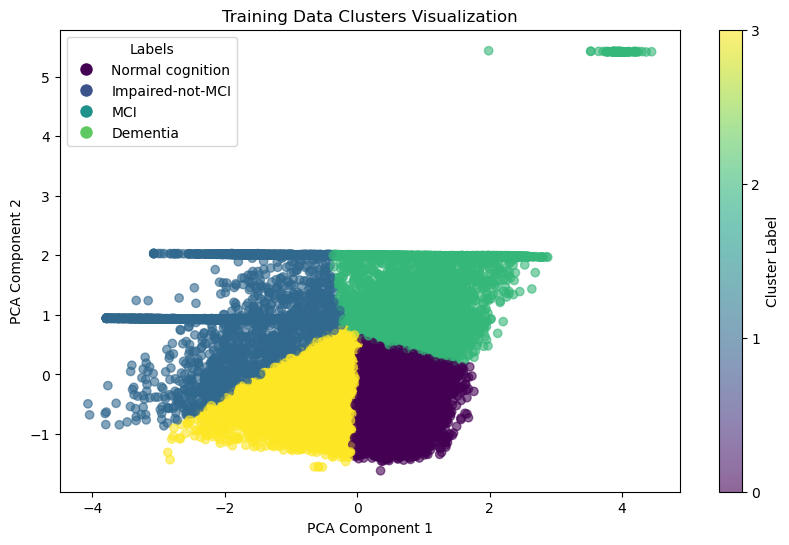

                  precision    recall  f1-score   support

Normal cognition       0.38      0.75      0.50        76
Impaired-not-MCI       0.00      0.00      0.00        92
             MCI       0.35      0.23      0.27        80
        Dementia       0.10      0.09      0.09        80

        accuracy                           0.25       328
       macro avg       0.20      0.27      0.22       328
    weighted avg       0.20      0.25      0.20       328



In [53]:
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from clustering.Clustering import Clustering
from sklearn.decomposition import PCA

suitable_word_embedded_columns = ["COMMUN", "HOMEHOBB", "JUDGMENT", "MEMORY"]

main_df = pd.read_csv("./undersampled_df.csv")

# delete the rows with 99 in it (missing value)
main_df = main_df[~main_df[suitable_word_embedded_columns].eq(99).any(axis=1)]
columns_to_drop = ["NACCID", "VISITDT"]

# Check if the columns exist in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in main_df.columns]

# Drop the columns if they exist
if columns_to_drop:
    main_df = main_df.drop(columns=columns_to_drop)


column_combinations = [["COMMUN", "HOMEHOBB", "JUDGMENT", "MEMORY"]]

# generate all combinations of different word embeddings
#for r in range(1, len(suitable_word_embedded_columns) + 1):
#    for combination in itertools.combinations(suitable_word_embedded_columns, r):
#        column_combinations.append(list(combination))

string_mapping = {
    0.0: 'no',
    0.5: 'uncertain',
    1.0: 'mild',
    2.0: 'moderate',
    3.0: 'severe',
}

for word_embedded_columns in column_combinations:
    
    dataframe = main_df.copy(deep = True)

    for col in word_embedded_columns:
        dataframe[col] = dataframe[col].map(string_mapping)

    # Features : X , Labels : y
    X, y = preprocess.sep_column(dataframe, "NACCUDSD")
    y = y.astype(int)

    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=462)

    X_train = preprocess.replace_with_word_embeddings(X_train, word_embeddings, word_embedded_columns)
    X_test = preprocess.replace_with_word_embeddings(X_test, word_embeddings, word_embedded_columns)

    
    pca = PCA(n_components=2)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    

    y_train = y_train - 1
    y_test = y_test - 1

    print(y_train.value_counts())

    clustering = Clustering(n_clusters=4)
    clustering.fit(X_train, X_test, y_train, y_test)
    
    # Visualize the clusters for training and test data
    clustering.visualize('train')
    
    clustering.print_classification_report('test')